# Data Preprocess

In [2]:
import pandas as pd

# Load the data
hpg_data = pd.read_csv('HPG.csv', parse_dates=['Date'])
mwg_data = pd.read_csv('MWG.csv', parse_dates=['Date'])

# Convert 'Price' column to numeric
hpg_data['Price'] = pd.to_numeric(hpg_data['Price'].str.replace(',', ''), errors='coerce')
mwg_data['Price'] = pd.to_numeric(mwg_data['Price'].str.replace(',', ''), errors='coerce')

# Set the 'Date' column as the index
hpg_data.set_index('Date', inplace=True)
mwg_data.set_index('Date', inplace=True)

# Sort the index
hpg_data.sort_index(inplace=True)
mwg_data.sort_index(inplace=True)

# Set the frequency of the index
hpg_data = hpg_data.asfreq('B')
mwg_data = mwg_data.asfreq('B')

# Fill missing values if any (forward fill)
hpg_data['Price'].ffill(inplace=True)
mwg_data['Price'].ffill(inplace=True)

# Split the data into training and testing sets
train_hpg = hpg_data[:'2022-02-28']
test_hpg = hpg_data['2022-03-01':]

train_mwg = mwg_data[:'2022-02-28']
test_mwg = mwg_data['2022-03-01':]

train_hpg.shape, test_hpg.shape, train_mwg.shape, test_mwg.shape

((1085, 6), (544, 6), (1085, 6), (544, 6))

# ARIMA Model
### Stationarity Test and Differencing

In [19]:
import pandas as pd
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

# Function to perform Dickey-Fuller test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    return result[1]

# Perform the test on the training data
print("HPG ADF Test:")
hpg_p_value = adf_test(train_hpg['Price'])

print("\nMWG ADF Test:")
mwg_p_value = adf_test(train_mwg['Price'])

HPG ADF Test:
ADF Statistic: -0.032357448049534145
p-value: 0.9557729319084692

MWG ADF Test:
ADF Statistic: 0.3708115507627589
p-value: 0.9803699650500115


### Model Training and Prediction

In [11]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Function to fit ARIMA model and make predictions
def arima_model(train, test, order):
    # Fit ARIMA model
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    print(model_fit.summary())

    # Ensure the index format matches
    start_index = test.index[0]
    end_index = test.index[-1]
    
    # Print the index to debug
    print(f"Start Index: {start_index}, End Index: {end_index}")
    print(f"Train Index: {train.index}")
    print(f"Test Index: {test.index}")

    # Make predictions
    predictions = model_fit.predict(start=start_index, end=end_index)
    return predictions

# Fit ARIMA model and make predictions for HPG
hpg_predictions = arima_model(train_hpg['Price'], test_hpg['Price'], (0, 0, 4))

# Fit ARIMA model and make predictions for MWG
mwg_predictions = arima_model(train_hpg['Price'], test_hpg['Price'], (5, 2, 0))

# Save predictions to CSV
hpg_predictions.to_csv('hpg_arima_predictions.csv')
mwg_predictions.to_csv('mwg_arima_predictions.csv')


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 1085
Model:                 ARIMA(0, 0, 4)   Log Likelihood              -10171.019
Date:                Fri, 31 May 2024   AIC                          20354.038
Time:                        23:46:29   BIC                          20383.974
Sample:                    01-02-2018   HQIC                         20365.370
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.858e+04    541.851     34.293      0.000    1.75e+04    1.96e+04
ma.L1          1.4881      0.026     58.241      0.000       1.438       1.538
ma.L2          1.5217      0.031     48.904      0.0

In [10]:
from sklearn.metrics import mean_squared_error

# Function for grid search of ARIMA parameters
def grid_search_arima(train, test):
    best_score, best_cfg = float("inf"), None
    for p in range(0, 7):
        for d in range(0, 3):
            for q in range(0, 7):
                order = (p, d, q)
                try:
                    model = ARIMA(train, order=order)
                    model_fit = model.fit()
                    predictions = model_fit.predict(start=test.index[0], end=test.index[-1])
                    mse = mean_squared_error(test, predictions)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print(f"ARIMA{order} MSE={mse}")
                except Exception as e:
                    print(f"Error with ARIMA{order}: {e}")
                    continue
    print(f"Best ARIMA{best_cfg} MSE={best_score}")
    return best_cfg

# Find best ARIMA parameters for HPG
best_order_hpg = grid_search_arima(train_hpg['Price'], test_hpg['Price'])

# Find best ARIMA parameters for MWG
best_order_mwg = grid_search_arima(train_mwg['Price'], test_mwg['Price'])

ARIMA(0, 0, 0) MSE=42325881.093539014
ARIMA(0, 0, 1) MSE=41948391.57266099
ARIMA(0, 0, 2) MSE=41537300.461434714
ARIMA(0, 0, 3) MSE=41364886.57690722
ARIMA(0, 0, 4) MSE=40403386.800679445
ARIMA(0, 0, 5) MSE=41365475.09789091
ARIMA(0, 0, 6) MSE=40643210.3930684
ARIMA(0, 1, 0) MSE=194311280.3024448
ARIMA(0, 1, 1) MSE=194736290.54457736
ARIMA(0, 1, 2) MSE=193660789.52052882
ARIMA(0, 1, 3) MSE=193436830.96842164
ARIMA(0, 1, 4) MSE=194237324.04147962
ARIMA(0, 1, 5) MSE=194126108.63862756
ARIMA(0, 1, 6) MSE=194158779.26261222
ARIMA(0, 2, 0) MSE=102918148402.68861
ARIMA(0, 2, 1) MSE=437322575.2627846
ARIMA(0, 2, 2) MSE=430065680.6634837
ARIMA(0, 2, 3) MSE=417963515.176085
ARIMA(0, 2, 4) MSE=218899768.03936583
ARIMA(0, 2, 5) MSE=423501314.3862815
ARIMA(0, 2, 6) MSE=259911823.31313694
ARIMA(1, 0, 0) MSE=122515295.53733084
ARIMA(1, 0, 1) MSE=127175067.64308587
ARIMA(1, 0, 2) MSE=131304636.61866868
ARIMA(1, 0, 3) MSE=135189949.96411484
ARIMA(1, 0, 4) MSE=130876875.2348888
ARIMA(1, 0, 5) MSE=13260

### Evaluation

In [15]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# Function to evaluate model predictions
def evaluate_model(test, predictions):
    mse = mean_squared_error(test, predictions)
    mape = mean_absolute_percentage_error(test, predictions)
    r2 = r2_score(test, predictions)
    return mse, mape, r2

# Evaluate ARIMA model for HPG
hpg_mse, hpg_mape, hpg_r2 = evaluate_model(test_hpg['Price'], hpg_predictions)
print(f"HPG ARIMA Model - MSE: {hpg_mse}, MAPE: {hpg_mape}, R2: {hpg_r2}")

# Evaluate ARIMA model for MWG
mwg_mse, mwg_mape, mwg_r2 = evaluate_model(test_mwg['Price'], mwg_predictions)
print(f"MWG ARIMA Model - MSE: {mwg_mse}, MAPE: {mwg_mape}, R2: {mwg_r2}")

HPG ARIMA Model - MSE: 40403386.800679445, MAPE: 0.19438488530777356, R2: -0.6024521579460318
MWG ARIMA Model - MSE: 2253436460.0153766, MAPE: 0.9063980481754799, R2: -14.321874157516799


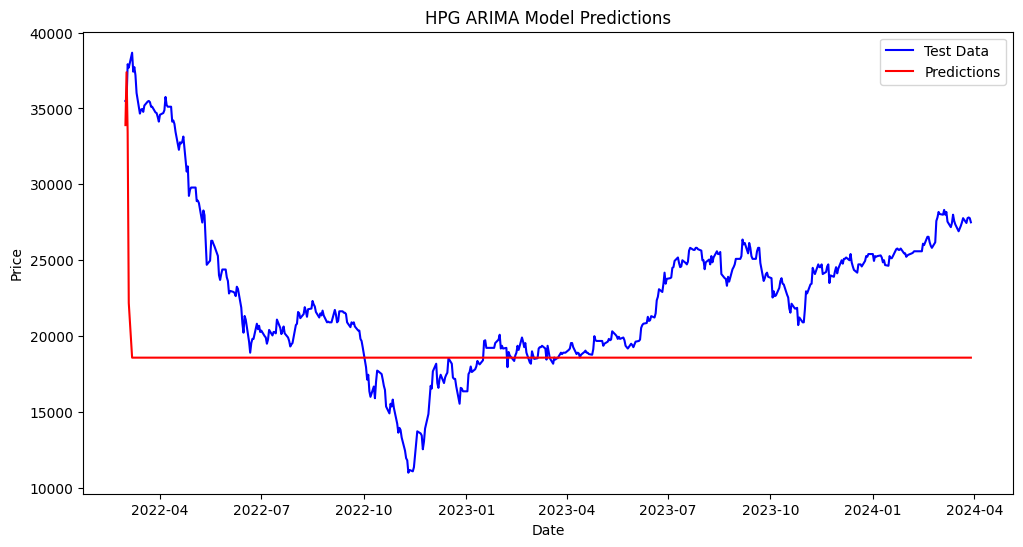

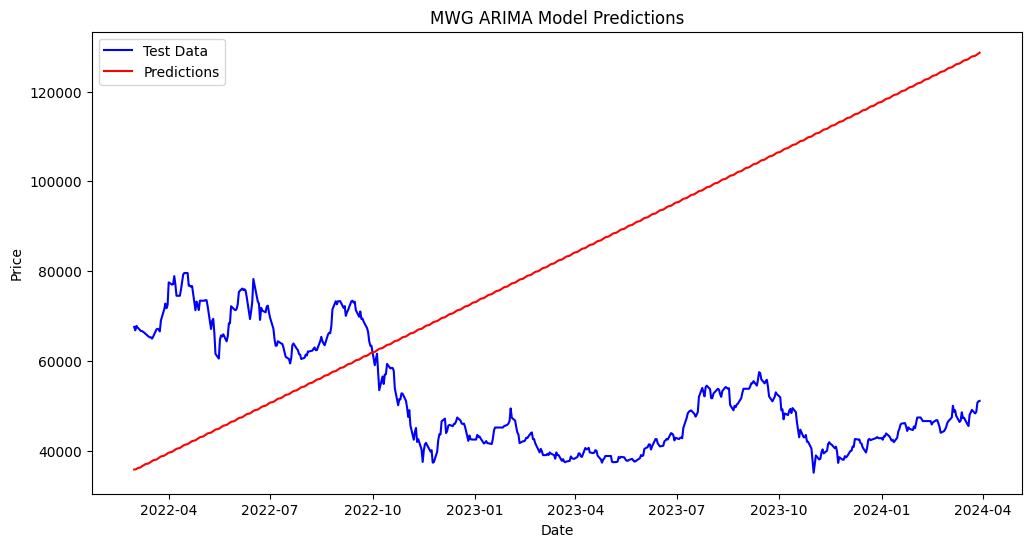

In [17]:
import matplotlib.pyplot as plt

# Plotting the test and prediction values
def plot_predictions(test, predictions, title):
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, test, label='Test Data', color='blue')
    plt.plot(predictions.index, predictions, label='Predictions', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Plot predictions for HPG
plot_predictions(test_hpg['Price'], hpg_predictions, 'HPG ARIMA Model Predictions')

# Plot predictions for MWG
plot_predictions(test_mwg['Price'], mwg_predictions, 'MWG ARIMA Model Predictions')

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=16308.149, Time=1.29 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=16311.257, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=16312.157, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=16312.372, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=16311.853, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=16307.144, Time=1.02 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=16309.681, Time=0.43 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=16305.498, Time=2.73 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=16307.326, Time=3.92 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=16312.048, Time=1.21 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=16311.655, Time=1.41 sec
 ARIMA(3,1,2)(0,0,2)[12] intercept   : AIC=16310.442, Time=3.07 sec
 ARIMA(2,1,3)(0,0,2)[12] intercept   : AIC=16307.253, Time=4.71 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=16312.675, Time=1.81 sec
 ARIM

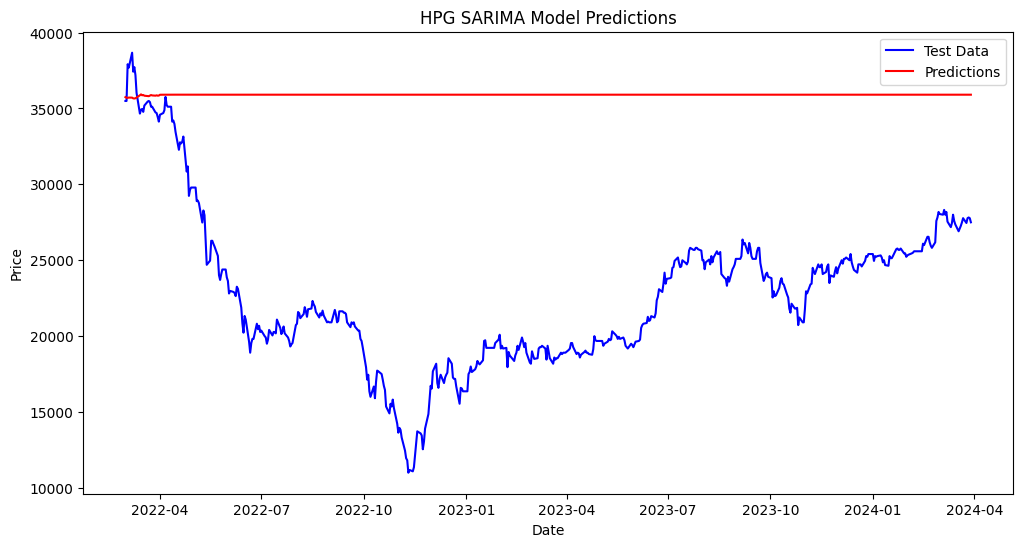

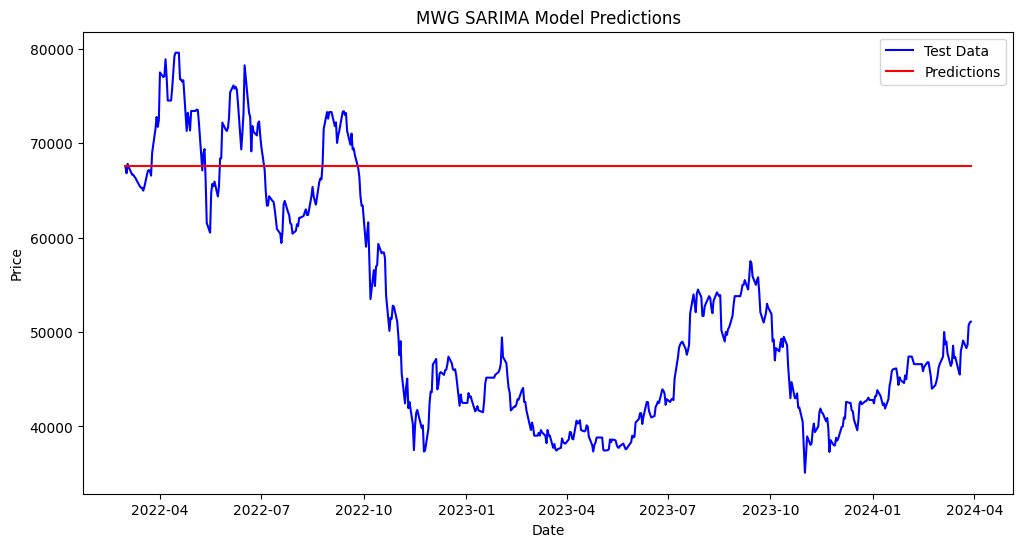

In [21]:
import pandas as pd
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
# Function to find the best SARIMA model and make predictions
def sarima_model_auto(train, test, seasonal_period):
    # Use auto_arima to find the best order including seasonal component
    auto_model = auto_arima(train, seasonal=True, m=seasonal_period, trace=True, error_action='ignore', suppress_warnings=True)
    order = auto_model.order
    seasonal_order = auto_model.seasonal_order
    
    # Fit SARIMA model
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    print(model_fit.summary())
    
    # Make predictions
    start_index = test.index[0]
    end_index = test.index[-1]
    predictions = model_fit.predict(start=start_index, end=end_index)
    return predictions, order, seasonal_order

# Define the seasonal period (e.g., 12 for monthly data)
seasonal_period = 12

# Fit SARIMA model and make predictions for HPG
hpg_predictions, hpg_order, hpg_seasonal_order = sarima_model_auto(train_hpg['Price'], test_hpg['Price'], seasonal_period)

# Fit SARIMA model and make predictions for MWG
mwg_predictions, mwg_order, mwg_seasonal_order = sarima_model_auto(train_mwg['Price'], test_mwg['Price'], seasonal_period)

# Save predictions to CSV
hpg_predictions.to_csv('hpg_sarima_predictions.csv')
mwg_predictions.to_csv('mwg_sarima_predictions.csv')

# Function to evaluate model predictions
def evaluate_model(test, predictions):
    mse = mean_squared_error(test, predictions)
    mape = mean_absolute_percentage_error(test, predictions)
    r2 = r2_score(test, predictions)
    return mse, mape, r2

# Evaluate SARIMA model for HPG
hpg_mse, hpg_mape, hpg_r2 = evaluate_model(test_hpg['Price'], hpg_predictions)
print(f"HPG SARIMA Model - MSE: {hpg_mse}, MAPE: {hpg_mape}, R2: {hpg_r2}")

# Evaluate SARIMA model for MWG
mwg_mse, mwg_mape, mwg_r2 = evaluate_model(test_mwg['Price'], mwg_predictions)
print(f"MWG SARIMA Model - MSE: {mwg_mse}, MAPE: {mwg_mape}, R2: {mwg_r2}")

# Plotting the test and prediction values
def plot_predictions(test, predictions, title):
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, test, label='Test Data', color='blue')
    plt.plot(predictions.index, predictions, label='Predictions', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Plot predictions for HPG
plot_predictions(test_hpg['Price'], hpg_predictions, 'HPG SARIMA Model Predictions')

# Plot predictions for MWG
plot_predictions(test_mwg['Price'], mwg_predictions, 'MWG SARIMA Model Predictions')

# LSTM Model
### Data Scaling

In [7]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Function to scale data
def scale_data(train, test):
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
    test_scaled = scaler.transform(test.values.reshape(-1, 1))
    return scaler, train_scaled, test_scaled

# Scale the data for HPG and MWG
hpg_scaler, train_hpg_scaled, test_hpg_scaled = scale_data(train_hpg['Price'], test_hpg['Price'])
mwg_scaler, train_mwg_scaled, test_mwg_scaled = scale_data(train_mwg['Price'], test_mwg['Price'])

### Model Training and Prediction

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Function to create and train LSTM model
def train_lstm(train_scaled, test_scaled, epochs=100, batch_size=1):
    # Prepare the data for LSTM
    X_train, y_train = [], []
    for i in range(1, len(train_scaled)):
        X_train.append(train_scaled[i-1:i, 0])
        y_train.append(train_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

    # Make predictions
    X_test = []
    for i in range(1, len(test_scaled)):
        X_test.append(test_scaled[i-1:i, 0])
    X_test = np.array(X_test)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    predictions = model.predict(X_test)
    return model, predictions

# Train LSTM model and make predictions for HPG
hpg_model, hpg_predictions_scaled = train_lstm(train_hpg_scaled, test_hpg_scaled)

# Train LSTM model and make predictions for MWG
mwg_model, mwg_predictions_scaled = train_lstm(train_mwg_scaled, test_mwg_scaled)

# Inverse transform predictions
hpg_predictions = hpg_scaler.inverse_transform(hpg_predictions_scaled)
mwg_predictions = mwg_scaler.inverse_transform(mwg_predictions_scaled)

# Save predictions to CSV
np.savetxt('hpg_lstm_predictions.csv', hpg_predictions, delimiter=',')
np.savetxt('mwg_lstm_predictions.csv', mwg_predictions, delimiter=',')




Epoch 1/100

1084/1084 - 6s - loss: 0.0088 - 6s/epoch - 5ms/step
Epoch 2/100
1084/1084 - 2s - loss: 3.5108e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1084/1084 - 2s - loss: 2.5759e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1084/1084 - 2s - loss: 2.9088e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1084/1084 - 2s - loss: 3.0839e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1084/1084 - 2s - loss: 3.2856e-04 - 2s/epoch - 2ms/step
Epoch 7/100
1084/1084 - 2s - loss: 2.8114e-04 - 2s/epoch - 2ms/step
Epoch 8/100
1084/1084 - 2s - loss: 3.0542e-04 - 2s/epoch - 2ms/step
Epoch 9/100
1084/1084 - 2s - loss: 2.7378e-04 - 2s/epoch - 2ms/step
Epoch 10/100
1084/1084 - 2s - loss: 2.9320e-04 - 2s/epoch - 2ms/step
Epoch 11/100
1084/1084 - 2s - loss: 2.7908e-04 - 2s/epoch - 2ms/step
Epoch 12/100
1084/1084 - 2s - loss: 2.7995e-04 - 2s/epoch - 2ms/step
Epoch 13/100
1084/1084 - 2s - loss: 2.6875e-04 - 2s/epoch - 2ms/step
Epoch 14/100
1084/1084 - 2s - loss: 2.5525e-04 - 2s/epoch - 2ms/step
Epoch 15/100
1084/1084 - 2s - loss: 2.9813e

### Evaluation

In [ ]:
# Evaluate LSTM model for HPG
hpg_mse, hpg_mape, hpg_r2 = evaluate_model(test_hpg['Price'].values[1:], hpg_predictions)
print(f"HPG LSTM Model - MSE: {hpg_mse}, MAPE: {hpg_mape}, R2: {hpg_r2}")

# Evaluate LSTM model for MWG
mwg_mse, mwg_mape, mwg_r2 = evaluate_model(test_mwg['Price'].values[1:], mwg_predictions)
print(f"MWG LSTM Model - MSE: {mwg_mse}, MAPE: {mwg_mape}, R2: {mwg_r2}")